In [ ]:
#Deteccion de pising en correos

In [3]:
from google.colab import drive
drive.mount("/content/drive") #Debemos cargar el dataset

MessageError: Error: credential propagation was unsuccessful

In [21]:
#Librerias para manipulacion de datos
import pandas as pd
import numpy as np

#Librerias para limpieza y procesamiento de datos
import re
import string

#Librerias para visualización
import matplotlib.pyplot as plt
import seaborn as sns

#Librerias para Preprocesamiento de los datos
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

#Librerías para metricas de evaluación
from tensorflow.keras.models import Sequential      #Modelo de red neuronal
from tensorflow.keras.layers import Dense, Dropout  #Tipo de aprendizaje
from tensorflow.keras.optimizers import Adam        #Optimizador de fit



In [22]:
#Libreria para nube de palabras (esta es totalmente opccional)
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
#Cargar el archivo desde drive
dataFrame = pd.read_csv("/content/drive/MyDrive/pishing/CEAS_08.csv")

In [20]:
dataFrame['body'].apply(lambda x: len(x.strip())).describe()

,body
count,39154.000000
mean,1567.316060
std,3616.055523
min,11.000000
25%,219.000000
50%,562.000000
75%,1639.000000
max,143996.000000


In [24]:
dataFrame.head() #Mostramos los primeros datos para asegurarnos que se cargó correctamente

,sender,receiver,date,subject,body,label,urls
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1


In [25]:
#ADVERTENCIA: SOLO En caso de que los datos tengan mucho contenido HTML
#Ejecutar esta celda, en caso contrario ignorarlo

# debe ser del tipo <html></html>


from bs4 import BeautifulSoup

#Limpiar datos de HTML
def limpiarHTML(texto):
  return BeautifulSoup(texto, "html.parser").getText()

#Aplicar la limpieza a la comumna seleccionada
dataFrame["COLMUNA_A_LIMPIAR"] = dataFrame["COLMUNA_A_LIMPIAR"].apply(limpiarHTML)

KeyError: 'COLMUNA_A_LIMPIAR'

In [26]:
#Exploramos el contenido
print("Forma del dataset: ", dataFrame.shape)
print("Columas: ", dataFrame.columns.tolist())
print("Valores únicos en la etiqueta: ", dataFrame["label"].unique())

Forma del dataset:  (39154, 7)
Columas:  ['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls']
Valores únicos en la etiqueta:  [1 0]


In [27]:
#Lista de stopwords
stop_words = set(stopwords.words("english"))

In [28]:
#funciones de limpieza

def limpiarTexto(texto):
  if pd.isnull(texto): #si es nulo regresa vacio el texto
    return ""

    #---------NORMALIZAR los datos ------------
    #convertir a minusculas
    texto = texto.lower()

    #Eliminar URL
    texto = re.sub(r'http\S+|www.\S+', '', texto)

    #Eliminar correos electronicos
    texto = re.sub(r'\S+@\S+', '', texto)

    #Eliminar signos de puntuación
    texto = texto.translate(str.maketrans('', '', string.punctuation))

    #Limpieza de numeros
    texto = re.sub(r'\d+', '', texto)

    #liminar stopwords y espacios extra
    palabras = texto.split()
    #palabras = [p for p in palabras if p not in stop_words]
    palabras = [p for p in palabras if p not in stop_words and len(p) > 2]

    return " ".join(palabras)

In [29]:
#---Aplicamos limpieza de datos-----
#Aplicamos limpieza al cuerpo del correo

dataFrame["bodyClean"] = dataFrame["body"].apply(limpiarTexto)

#Revisar algunos ejemplos para comprobar la limpieza
dataFrame[["body", "bodyClean"]].sample(5)

,body,bodyClean
2525,"The man page for this setting states:\n\n""Note...",None
38133,\n\n\nCNN Alerts: My Custom Alert\n\n\n\n\n\n\...,None
19309,"On Thu, Mar 27, 2008 at 2:25 PM, Benjamin Pete...",None
36078,\n\n\nCNN Alerts: My Custom Alert\n\n\n\n\n\n\...,None
6804,\nWomen with menopause endorses product for me...,None


In [31]:
#-----Vectorizamos el texto ------------
#Aplicamos TF-IDF (Term Frequency - Inverse Document Frequency)

#Aplicamos la configuracion de TF-IDF
vectorizador = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words="english")
                        #Numero max de palabras unicas , Unigramas y bigramas

#Aplicar TFIDF sobre el texto limpio
#Aqui debemos seleccionar las columnas que queremos en el entrenamiento
#en este caso estamos discriminando las demás columnas porque son irrelevantes para este caso
dataFrame['bodyClean'] = dataFrame['body'].fillna("")
X = vectorizador.fit_transform(dataFrame["bodyClean"]).toarray()

#definimos las etiquetas

Y = dataFrame["label"].values


In [32]:
#INICIO NN
#Separar los datos entre entrenamiento y prueba
#Se seleccionó aleatoreamente 80-20

x_train,x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42, stratify=Y)

#Aquí ya debememos tener los datos vecttorizados en x_train, y_train


In [33]:
#---ENTRENAMIENTO DEL MODELO----

#Crear modelo

modelo = Sequential()
modelo.add(Dense(128, input_dim=x_train.shape[1], activation="relu"))
          #Tipo de capa densa, 128 neurononas, dimencion de entrada dictada por x_train, funcion de activacion
modelo.add(Dropout(0.5))    #Apagar el 50% de las neuronas para mejorar el modelo
modelo.add(Dense(64, activation="relu"))
modelo.add(Dropout(0.3))
modelo.add(Dense(1, activation="sigmoid")) #Capa de salida con clasificacion binaria



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [36]:
#Compilar el modelo
modelo.compile(
    loss='binary_crossentropy',           #Funcion de perdida
    optimizer=Adam(learning_rate=0.001),  #optimizados con ajuste de aprendizaje
    metrics=["accuracy"]
)

In [38]:
#Entrenar el modelo

history = modelo.fit(
    x_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/10
784/784 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9997 - loss: 0.0010 - val_accuracy: 0.9928 - val_loss: 0.0387
Epoch 2/10
784/784 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9995 - loss: 0.0015 - val_accuracy: 0.9923 - val_loss: 0.0380
Epoch 3/10
784/784 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.9998 - loss: 5.9419e-04 - val_accuracy: 0.9936 - val_loss: 0.0401
Epoch 4/10
784/784 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9999 - loss: 3.3844e-04 - val_accuracy: 0.9919 - val_loss: 0.0480
Epoch 5/10
784/784 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.9997 - loss: 8.7580e-04 - val_accuracy: 0.9930 - val_loss: 0.0460
Epoch 6/10
784/784 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9998 - loss: 8.9491e-04 - val_accuracy: 0.9925 - val_loss: 0.0466
Epoch 7/10
784/784 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.9999 - loss: 3.9004e-04 - val_accuracy: 0.9923 - val_loss: 0.0549
Epoch 8/10
784/784 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.99

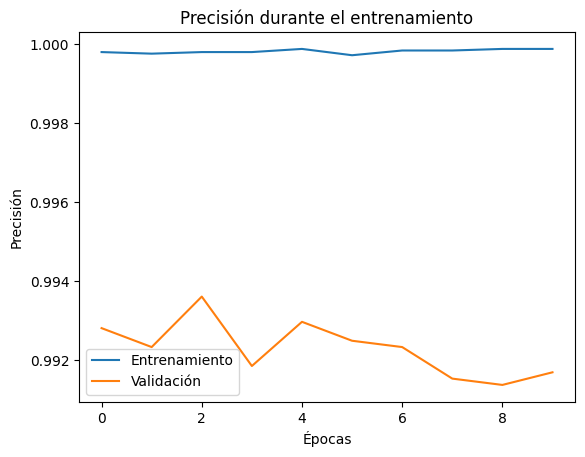

In [39]:
#Evaluacion del modelo
#visualizar el rendimiento
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

In [40]:
#Predicciones probabilisticas
y_pred_prob = modelo.predict(x_test)

#convertir a clases (0 a 1)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()


245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [41]:
#Reporte de metrícas

#Esto nos dará
#   Precision = de todos los datos que marcamos como pishing, cuáles si eran ?
#   recall = de los que si eran pishing, cuántos detectamos?
#   f1-score = equilibrio entre ambos
#   accuracy = cuantos clasificamos bien?

print(classification_report(y_test, y_pred, target_names=['Legítimo', 'Phishing']))


              precision    recall  f1-score   support

    Legítimo       0.99      0.99      0.99      3462
    Phishing       1.00      0.99      0.99      4369

    accuracy                           0.99      7831
   macro avg       0.99      0.99      0.99      7831
weighted avg       0.99      0.99      0.99      7831



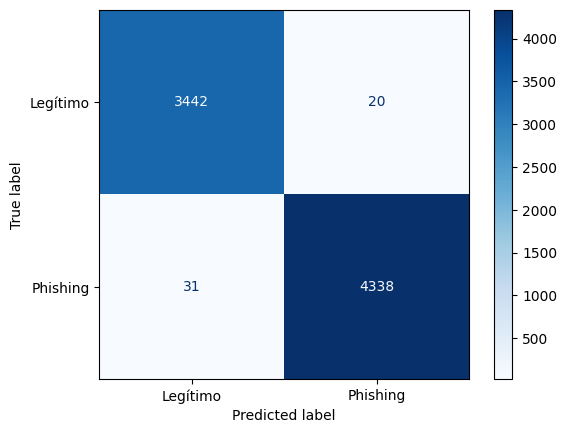

In [42]:
#Generar matriz de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Legítimo', 'Phishing'])
disp.plot(cmap='Blues')


In [43]:
!pip install wordcloud


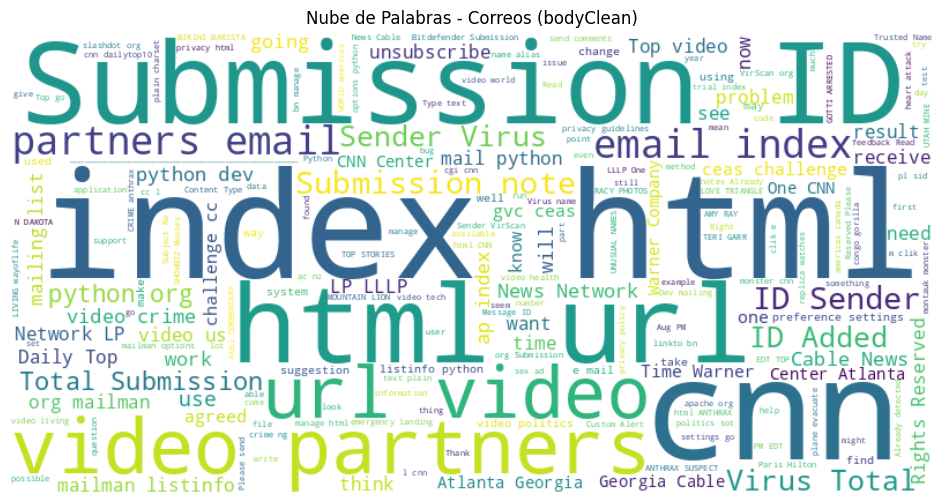

In [44]:
#Generar nube de palabras

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Unir todos los textos en un solo string
texto_completo = " ".join(dataFrame['bodyClean'].tolist())

# Generar nube de palabras
nube = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(texto_completo)

# Mostrarla
plt.figure(figsize=(12, 6))
plt.imshow(nube, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras - Correos (bodyClean)')
plt.show()

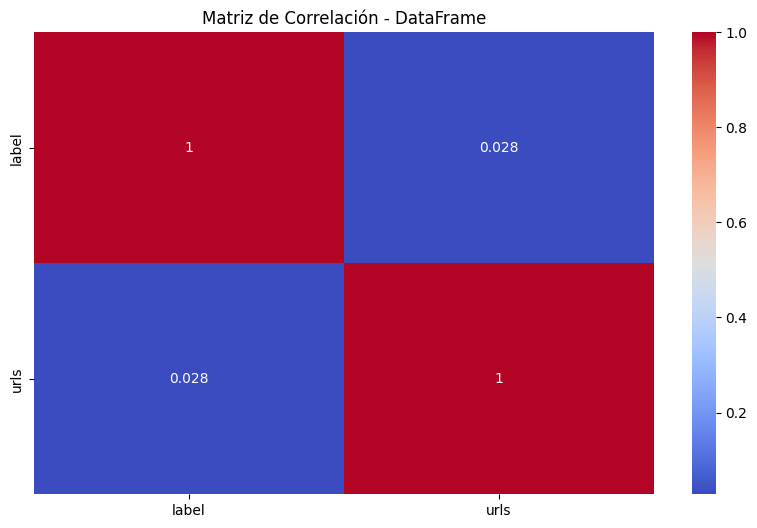

In [45]:
#Matriz de correlaccion
plt.figure(figsize=(10, 6))
sns.heatmap(dataFrame.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación - DataFrame')
plt.show()

## FIN :)